# Atividade 1 - Regressão Linear

## Aprendizado de Máquina - IA048

Profs.: Levy Boccato e Romis Attux

Aluno: Álvaro Tona Ribas Cruz

Data: Abril 2024

## Imports

In [185]:
# Warnings
import warnings
warnings.simplefilter('ignore')
# Data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
# ML
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Time series
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import RecursiveTabularRegressionForecaster
from sktime.forecasting.compose import RecursiveTimeSeriesRegressionForecaster

## Exercício 1

Leitura da base de dados

In [165]:
df = pd.read_csv(r"C:\Users\Álvaro Ribas\IA048_1S24\atividade-1_air_traffic_dataset.csv", sep=';', header=0)
df

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
0,2003,1,"43,032,450","4,905,830","47,938,280","785,16","57,667","842,827","36,211,422","12,885,980","49,097,402","56,191,300","17,968,572","74,159,872",64.44,71.71,66.20
1,2003,2,"41,166,780","4,245,366","45,412,146","690,351","51,259","741,61","34,148,439","10,715,468","44,863,907","50,088,434","15,587,880","65,676,314",68.18,68.74,68.31
2,2003,3,"49,992,700","5,008,613","55,001,313","797,194","58,926","856,12","41,774,564","12,567,068","54,341,633","57,592,901","17,753,174","75,346,075",72.53,70.79,72.12
3,2003,4,"47,033,260","4,345,444","51,378,704","766,26","55,005","821,265","39,465,980","10,370,592","49,836,572","54,639,679","15,528,761","70,168,440",72.23,66.78,71.02
4,2003,5,"49,152,352","4,610,834","53,763,186","789,397","55,265","844,662","41,001,934","11,575,026","52,576,960","55,349,897","15,629,821","70,979,718",74.08,74.06,74.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023,5,"71,423,653","10,358,666","81,782,319","667,331","71,924","739,255","66,743,565","26,805,432","93,548,998","77,821,407","31,950,687","109,772,094",85.77,83.90,85.22
245,2023,6,"72,482,621","11,544,505","84,027,126","661,293","75,279","736,572","68,789,127","29,883,465","98,672,591","78,058,358","33,410,671","111,469,028",88.13,89.44,88.52
246,2023,7,"75,378,157","12,432,615","87,810,772","684,939","79,738","764,677","72,267,904","31,376,000","103,643,904","81,986,010","35,326,191","117,312,202",88.15,88.82,88.35
247,2023,8,"71,477,988","11,572,149","83,050,137","691,482","77,137","768,619","67,933,484","29,938,507","97,871,992","81,997,399","34,908,793","116,906,192",82.85,85.76,83.72


Gráfico do total de voos em todo o período

Text(0.5, 1.0, 'Total number of flights (domestic and international)')

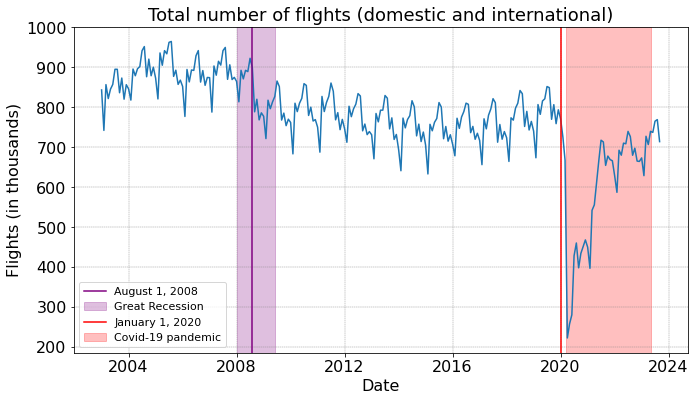

In [166]:
# Distribuição de datas (anos e meses)
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Adequação de formato: str -> int
total_flights = [x.replace(',','.') for x in df['Flt']]
total_flights = [float(y) for y in total_flights]

#Datas de interesse
economic_crisis = pd.Timestamp('2008-08-01')
covid_19 = pd.Timestamp('2020-01-01')

crisis_begin = pd.Timestamp('2008-01-01')
crisis_end = pd.Timestamp('2009-06-01')
covid_19_begin = pd.Timestamp('2020-03-11')
covid_19_end = pd.Timestamp('2023-05-05')

begin_2021 = pd.Timestamp('2021-01-01')
end_2021 = pd.Timestamp('2022-01-01')

#Formatação do gráfico
fig, axes = plt.subplots(1,1,figsize=(11,6), squeeze=False)

ax = axes[0][0]
ax.plot(df['date'], total_flights)
plt.axvline(economic_crisis, color = 'purple', label = 'August 1, 2008')
plt.axvspan(crisis_begin, crisis_end, color='purple', alpha=0.25, label='Great Recession')
plt.axvline(covid_19, color = 'red', label = 'January 1, 2020')
plt.axvspan(covid_19_begin, covid_19_end, color='red', alpha=0.25, label='Covid-19 pandemic')

ax.grid(color='gray', ls='dashed', lw=0.4)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=11)
ax.set_ylabel('Flights (in thousands)', size=16)
ax.set_xlabel('Date', size=16)
ax.set_title('Total number of flights (domestic and international)', size=18)

# Salvar imagem no diretório
# plt.savefig('atividade1_exc1_2')

Médias anuais de voos

In [167]:
def split_list(lista, chunk_size):
    return [lista[i:i + chunk_size] for i in range(0, len(lista), chunk_size)]

chunk_size = 12
flights_years = split_list(total_flights, chunk_size)

flights_year_avg = []
for i in range(len(flights_years)):
    flights_year_avg.append(np.average(flights_years[i]))

print(flights_year_avg)

[844.6802499999999, 891.6385833333334, 902.15675, 876.7868333333332, 889.2863333333333, 850.1666666666666, 795.1933333333332, 791.587, 788.0347499999999, 772.2784166666665, 762.7078333333333, 746.2018333333334, 741.3843333333334, 752.1421666666665, 751.8200833333334, 771.4000000000001, 788.6431666666667, 463.36375, 609.59025, 681.2096666666666, 717.4411111111111]


## Exercício 2

Conjunto de treinamento

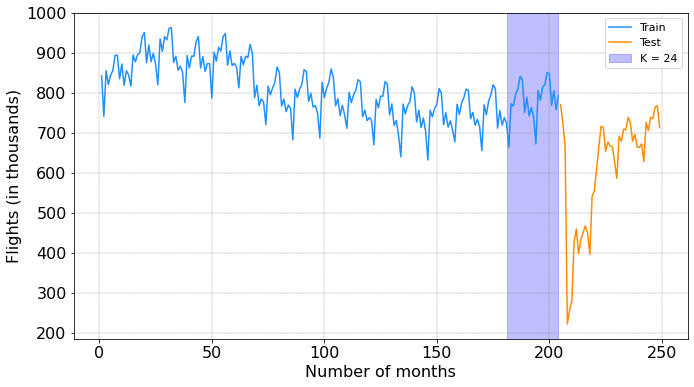

In [170]:
# Definir datas do evento
df_train = df[df['date'] < covid_19]
df_test = df[df['date'] >= covid_19]

# Criar conjuntos e tamanhos
dates_train = list(df_train['date'])
dates_train = np.array([x+1 for x in range(len(dates_train))]) # conversão de datas para número de meses
flights_train = np.array(total_flights[:-45]) # repersenta todo o período antes da pandemia
train_size = len(flights_train)

dates_test = list(df_test['date'])
dates_test = np.array([train_size+x+1 for x in range(len(dates_test))]) # conversão de datas para número de meses
flights_test = np.array(total_flights[-45:]) # representam os 45 meses entre Jan/20 e Set/23
pred_horizon = np.arange(len(flights_test)) + 1

# Grafico
fig, axes = plt.subplots(1,1,figsize=(11,6), squeeze=False)

ax = axes[0][0]
ax.plot(dates_train, flights_train, label='Train', color='dodgerblue')
ax.plot(dates_test, flights_test, label='Test', color='darkorange')
plt.axvspan(dates_train[-24], dates_train[-1], label='K = 24', color='blue', alpha=0.25)
ax.grid(color='gray', ls='dashed', lw=0.4)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=11)
ax.set_ylabel('Flights (in thousands)',size=16)
ax.set_xlabel('Number of months', size=16)
# ax.set_title('Training and test sets', size=18)

# Salvar imagem no diretório
# plt.savefig('atividade1_exc2_1')

Gráfico de desempenho da janela de predição

In [ ]:
def optimal_value(list, n):
    k_min = list.index(min(list))
    return k_min

L = 1 # Horizonte de predição

rmse = []
mape = []

for K in range(24):

    linreg_forecaster = RecursiveTabularRegressionForecaster(linreg, window_length=K+1)
    linreg_forecaster.fit(flights_train)
    y_pred = np.array(linreg_forecaster.predict(L))[0]

    RMSE = mean_squared_error(flights_test[:1], y_pred, squared=False)
    rmse.append(RMSE)
    MAPE = mean_absolute_percentage_error(flights_test[:1], y_pred)
    mape.append(MAPE)

Text(0.5, 0, 'K')

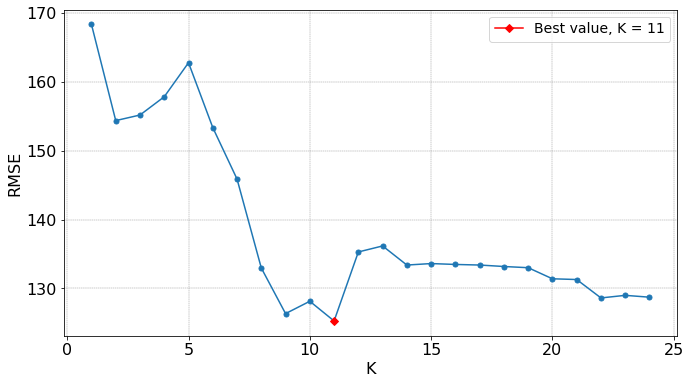

In [255]:
# Valores de K e seu melhor valor
K = [i+1 for i in range(24)]
k_min = optimal_value(rmse, len(rmse))

# Grafico
fig, axes = plt.subplots(1,1, figsize=(11,6), squeeze=False) #gridspec_kw={'width_ratios':[2,1]})

ax = axes[0][0]
ax.plot(K, rmse, marker='o', markersize=5)
ax.plot(K[k_min], rmse[k_min], marker='D', markersize=5, color='red', label='Best value, K = {}'.format(k_min+1))
ax.grid(color='gray', ls='dashed', lw=0.4)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=14)
ax.set_ylabel('RMSE',size=16)
ax.set_xlabel('K', size=16)
# ax.set_title('(a)', size=18)

# ax = axes[0][0]
# ax.plot(dates_train[-11:], flights_train[-11:], color='dodgerblue')
# ax.grid(color='gray', ls='dashed', lw=0.4)
# ax.tick_params(axis='both', labelsize=16)
# # ax.legend(fontsize=14)
# ax.set_ylabel('Flights (in thousands)',size=16)
# ax.set_xlabel('Number of months', size=16)
# ax.set_title('(b)', size=18)

# Salvar imagem no diretório
# plt.savefig('atividade1_exc2_21')

Resultado da melhor versão do preditor

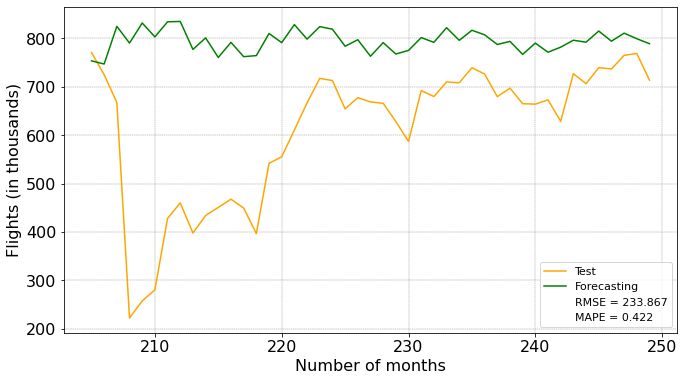

In [245]:
# Melhor resultado 
K = 11
pred_horizon = np.arange(len(flights_test)) + 1

# Ajuste
linreg = LinearRegression()
linreg_forecaster = RecursiveTabularRegressionForecaster(linreg, window_length=K) # Tamanho arbitrário de janela
linreg_forecaster.fit(flights_train)
y_pred = linreg_forecaster.predict(pred_horizon)

# RMSE e MAPE
RMSE = mean_squared_error(flights_test, y_pred, squared=False)
MAPE = mean_absolute_percentage_error(flights_test, y_pred)

# Grafico
fig, axes = plt.subplots(1,1,figsize=(11,6), squeeze=False)

ax = axes[0][0]
ax.plot(dates_test, flights_test, label='Test', color='orange')
ax.plot(dates_test, y_pred, label='Forecasting', color='green')
ax.plot([],[], label='RMSE = {0:.3f}'.format(RMSE), color='white')
ax.plot([],[], label='MAPE = {0:.3f}'.format(MAPE), color='white')
ax.grid(color='gray', ls='dashed', lw=0.4)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=11)
ax.set_ylabel('Flights (in thousands)',size=16)
ax.set_xlabel('Number of months', size=16)
# ax.set_title('Training and test sets', size=18)

# Salvar imagem no diretório
plt.savefig('atividade1_exc2_3')

Resultado da melhor versão para o final da série de teste

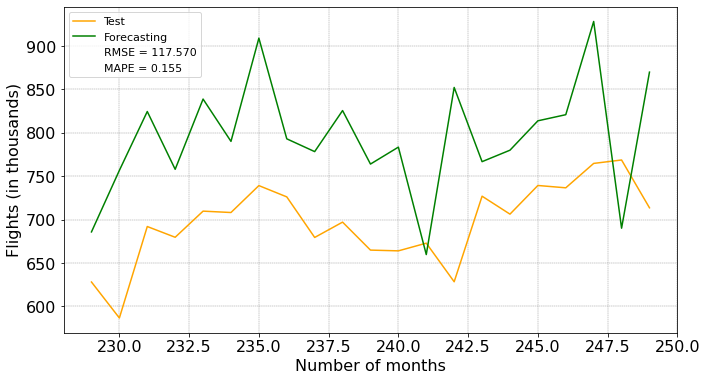

In [250]:
# Novo período
T = 21

# Melhor resultado 
K = 11
pred_horizon = np.arange(len(flights_test[-T:])) + 1

# Ajuste
linreg = LinearRegression()
linreg_forecaster = RecursiveTabularRegressionForecaster(linreg, window_length=K) # Tamanho arbitrário de janela
linreg_forecaster.fit(flights_train[-T:])
y_pred = linreg_forecaster.predict(pred_horizon)

# RMSE e MAPE
RMSE = mean_squared_error(flights_test[-T:], y_pred, squared=False)
MAPE = mean_absolute_percentage_error(flights_test[-T:], y_pred)

# Grafico
fig, axes = plt.subplots(1,1,figsize=(11,6), squeeze=False)

ax = axes[0][0]
ax.plot(dates_test[-T:], flights_test[-T:], label='Test', color='orange')
ax.plot(dates_test[-T:], y_pred, label='Forecasting', color='green')
ax.plot([],[], label='RMSE = {0:.3f}'.format(RMSE), color='white')
ax.plot([],[], label='MAPE = {0:.3f}'.format(MAPE), color='white')
ax.grid(color='gray', ls='dashed', lw=0.4)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=11)
ax.set_ylabel('Flights (in thousands)',size=16)
ax.set_xlabel('Number of months', size=16)
# ax.set_title('Training and test sets', size=18)

# Salvar imagem no diretório
plt.savefig('atividade1_exc2_4')

In [253]:
vp_rmse = (233.867 - 117.570)/233.287
vp_mape = (0.422 - 0.155)/0.422
print(vp_rmse)
print(vp_mape)

0.49851470506286244
0.6327014218009479


## Exercício 3

Nova divisão de conjuntos: treinamento, validação e teste

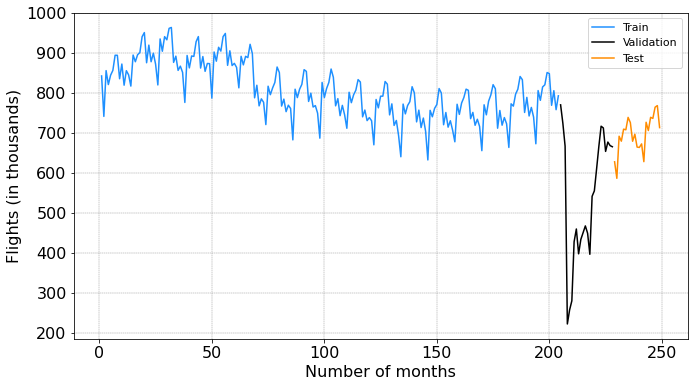

In [256]:
# Definir datas do evento
df_train = df[df['date'] < covid_19]
df_validation = df[(df['date'] >= covid_19) & (df['date'] < end_2021)]
df_test = df[df['date'] >= end_2021]

# Criar conjuntos e tamanhos
dates_train = list(df_train['date'])
dates_train = np.array([x+1 for x in range(len(dates_train))]) # conversão de datas para número de meses
flights_train = np.array(total_flights[:-45]) # repersenta todo o período antes da pandemia
train_size = len(flights_train)

dates_validation = list(df_validation['date']) 
dates_validation = np.array([train_size+x+1 for x in range(len(dates_validation))])
flights_validation = np.array(total_flights[-45:-21]) # representam período entre Jan/2020 e Jan/2022
validation_size = len(flights_validation) 

dates_test = list(df_test['date'])
dates_test = np.array([train_size+validation_size+x+1 for x in range(len(dates_test))]) # conversão de datas para número de meses
flights_test = np.array(total_flights[-21:]) # representam os 21 meses entre Jan/22 e Set/23
pred_horizon = np.arange(len(flights_test)) + 1

# Grafico
fig, axes = plt.subplots(1,1,figsize=(11,6), squeeze=False)

ax = axes[0][0]
ax.plot(dates_train, flights_train, label='Train', color='dodgerblue')
ax.plot(dates_validation, flights_validation, label='Validation', color='black')
ax.plot(dates_test, flights_test, label='Test', color='darkorange')
ax.grid(color='gray', ls='dashed', lw=0.4)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=11)
ax.set_ylabel('Flights (in thousands)',size=16)
ax.set_xlabel('Number of months', size=16)
# ax.set_title('Training and test sets', size=18)

# Salvar imagem no diretório
plt.savefig('atividade1_exc3_1')

Gráfico de desempenho da nova janela de predição

In [262]:
def optimal_value(list, n):
    k_min = list.index(min(list))
    return k_min

L = 1 # Horizonte de predição

rmse = []
mape = []

for K in range(24):

    linreg_forecaster = RecursiveTabularRegressionForecaster(linreg, window_length=K+1)
    linreg_forecaster.fit(flights_train)
    y_pred = np.array(linreg_forecaster.predict(L))[0]

    RMSE = mean_squared_error(flights_validation[:1], y_pred, squared=False)
    rmse.append(RMSE)
    MAPE = mean_absolute_percentage_error(flights_validation[:1], y_pred)
    mape.append(MAPE)

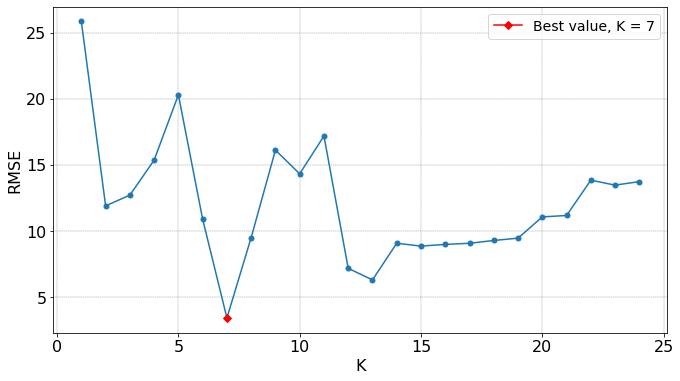

In [266]:
# Valores de K e seu melhor valor
K = [i+1 for i in range(24)]
k_min = optimal_value(rmse, len(rmse))

# Grafico
fig, axes = plt.subplots(1,1, figsize=(11,6), squeeze=False) #gridspec_kw={'width_ratios':[2,1]})

ax = axes[0][0]
ax.plot(K, rmse, marker='o', markersize=5)
ax.plot(K[k_min], rmse[k_min], marker='D', markersize=5, color='red', label='Best value, K = {}'.format(k_min+1))
ax.grid(color='gray', ls='dashed', lw=0.4)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=14)
ax.set_ylabel('RMSE',size=16)
ax.set_xlabel('K', size=16)
# ax.set_title('(a)', size=18)

# ax = axes[0][0]
# ax.plot(dates_train[-11:], flights_train[-11:], color='dodgerblue')
# ax.grid(color='gray', ls='dashed', lw=0.4)
# ax.tick_params(axis='both', labelsize=16)
# # ax.legend(fontsize=14)
# ax.set_ylabel('Flights (in thousands)',size=16)
# ax.set_xlabel('Number of months', size=16)
# ax.set_title('(b)', size=18)

# Salvar imagem no diretório
plt.savefig('atividade1_exc3_2')

Resultado da melhor versão do preditor

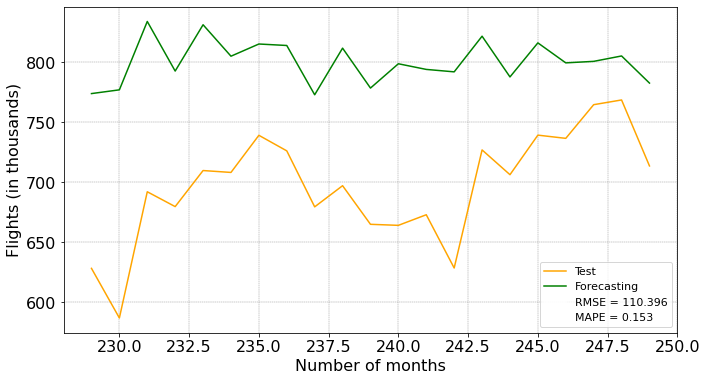

In [267]:
# Melhor resultado 
K = 7
pred_horizon = np.arange(len(flights_test)) + 1

# Ajuste
linreg = LinearRegression()
linreg_forecaster = RecursiveTabularRegressionForecaster(linreg, window_length=K) # Tamanho arbitrário de janela
linreg_forecaster.fit(flights_train)
y_pred = linreg_forecaster.predict(pred_horizon)

# RMSE e MAPE
RMSE = mean_squared_error(flights_test, y_pred, squared=False)
MAPE = mean_absolute_percentage_error(flights_test, y_pred)

# Grafico
fig, axes = plt.subplots(1,1,figsize=(11,6), squeeze=False)

ax = axes[0][0]
ax.plot(dates_test, flights_test, label='Test', color='orange')
ax.plot(dates_test, y_pred, label='Forecasting', color='green')
ax.plot([],[], label='RMSE = {0:.3f}'.format(RMSE), color='white')
ax.plot([],[], label='MAPE = {0:.3f}'.format(MAPE), color='white')
ax.grid(color='gray', ls='dashed', lw=0.4)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=11)
ax.set_ylabel('Flights (in thousands)',size=16)
ax.set_xlabel('Number of months', size=16)
# ax.set_title('Training and test sets', size=18)

# Salvar imagem no diretório
plt.savefig('atividade1_exc3_3')